# CNN for Classification

### Load the [data](http://pytorch.org/docs/master/torchvision/datasets.html)

In [1]:
import torch
import torchvision

In [3]:
# data loading and transforming libraries
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

In [4]:
# Define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

In [5]:
train_data = FashionMNIST(root='./data', train=True, download=True, transform=data_transform)
test_data = FashionMNIST(root='./data', train=False, download=True, transform=data_transform)

In [6]:
print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))

Train data, number of images:  60000
Test data, number of images:  10000


In [7]:
batch_size = 20

In [8]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [9]:
classes = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
     'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

### Visualize some training data

In [10]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [11]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

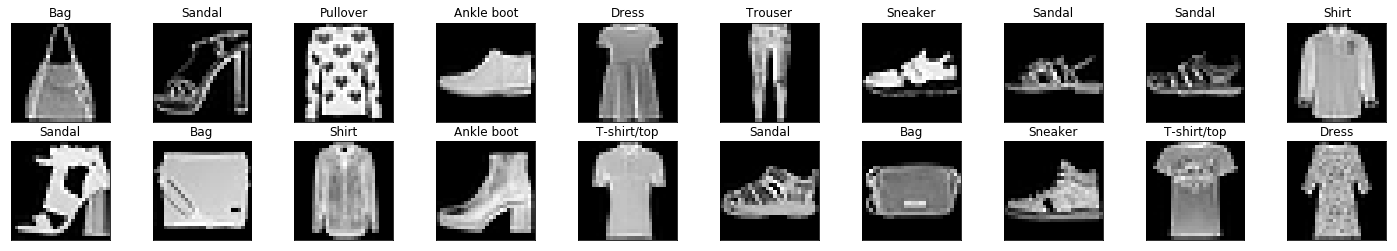

In [12]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

### Define the network architecture

In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        ## output size = (W-F)/S +1 = (28-3)/1 +1 = 26
        # the output Tensor for one image, will have the dimensions: (10, 26, 26)
        # after one pool layer, this becomes (10, 13, 13)
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool = nn.MaxPool2d(2, 2)
        
        # second conv layer: 10 inputs, 20 outputs, 3x3 conv
        ## output size = (W-F)/S +1 = (13-3)/1 +1 = 11
        # the output tensor will have dimensions: (20, 11, 11)
        # after another pool layer this becomes (20, 5, 5); 5.5 is rounded down
        self.conv2 = nn.Conv2d(10, 20, 3)
        
        # 20 outputs * the 5*5 filtered/pooled map size
        # 10 output channels (for the 10 classes)
        self.fc1 = nn.Linear(20*5*5, 10)
        

    def forward(self, x):
        # two conv/relu + pool layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # flatten the inputs into a vector
        x = x.view(x.size(0), -1)
        
        # one linear layer
        x = self.fc1(x)
        
        # a softmax layer to convert the 10 outputs into a distribution of class scores
        x = F.log_softmax(x, dim=1)
        
        return x

In [51]:
class Net1(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(10, 20, 3)
        
        self.fc1 = nn.Linear(20*5*5, 50)
        self.fc1_drop = nn.Dropout(p=0.4)

        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        
        x = self.fc2(x)
        
        return x

In [15]:
# instantiate and print your Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=10, bias=True)
)


### TODO: Specify the loss function and optimizer

In [16]:
import torch.optim as optim

In [17]:
# cross entropy loss combines softmax and nn.NLLLoss() in one single class

criterion = nn.NLLLoss()
# criterion = nn.CrossEntropyLoss()

In [18]:
optimizer = optim.SGD(net.parameters(), lr=0.001)
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### A note on accuracy

It's interesting to look at the accuracy of your network **before and after** training. This way you can really see that your network has learned something. In the next cell, let's see what the accuracy of an untrained network is (we expect it to be around 10% which is the same accuracy as just guessing for all 10 classes).

In [41]:
# Calculate accuracy before training
correct = 0
total = 0

for images, labels in test_loader:
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum()

accuracy = 100 * correct / total
print('Accuracy before training: ', accuracy.item())

Accuracy before training:  6


### Train the Network

Here are the steps that this training function performs as it iterates over the training dataset:

1. Zero's the gradients to prepare for a forward pass
2. Passes the input through the network (forward pass)
3. Computes the loss (how far is the predicted classes are from the correct labels)
4. Propagates gradients back into the network’s parameters (backward pass)
5. Updates the weights (parameter update)
6. Prints out the calculated loss

In [53]:
def train(n_epochs):
    loss_over_time = []
    
    for epoch in range(n_epochs):

        running_loss = 0.0
        for batch_i, data in enumerate(train_loader):
            inputs, labels = data       

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if batch_i % 1000 == 999:
                avg_loss = running_loss / 1000
                loss_over_time.append(avg_loss)
                
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print()
    print('Finished Training')
    return loss_over_time

In [54]:
n_epochs = 5
training_loss = train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 0.6053663631379604
Epoch: 1, Batch: 2000, Avg. Loss: 0.6122195876091718
Epoch: 1, Batch: 3000, Avg. Loss: 0.5976760727986693
Epoch: 2, Batch: 1000, Avg. Loss: 0.589429655879736
Epoch: 2, Batch: 2000, Avg. Loss: 0.5829353876709938
Epoch: 2, Batch: 3000, Avg. Loss: 0.5663336706012487
Epoch: 3, Batch: 1000, Avg. Loss: 0.5752869144827127
Epoch: 3, Batch: 2000, Avg. Loss: 0.5503588492125273
Epoch: 3, Batch: 3000, Avg. Loss: 0.5489974104017019
Epoch: 4, Batch: 1000, Avg. Loss: 0.5458911309242248
Epoch: 4, Batch: 2000, Avg. Loss: 0.5467678599208593
Epoch: 4, Batch: 3000, Avg. Loss: 0.5334579399824142
Epoch: 5, Batch: 1000, Avg. Loss: 0.5323161879628897
Epoch: 5, Batch: 2000, Avg. Loss: 0.5275628152638674
Epoch: 5, Batch: 3000, Avg. Loss: 0.5184618180245161

Finished Training


## Visualizing the loss

Text(0, 0.5, 'loss')

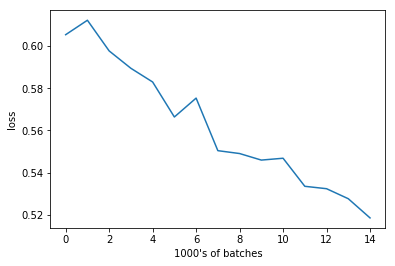

In [56]:
# visualize the loss as the network trained
plt.plot(training_loss)

plt.xlabel('1000\'s of batches')
plt.ylabel('loss')
# plt.ylim(0, 2.5) 

### Test the Trained Network

In [44]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):
    inputs, labels = data
    
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)
   
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

Test Loss: 0.636910



In [45]:
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

Test Accuracy of T-shirt/top: 70% (709/1000)
Test Accuracy of Trouser: 92% (920/1000)
Test Accuracy of Pullover: 67% (672/1000)
Test Accuracy of Dress: 77% (770/1000)
Test Accuracy of  Coat: 73% (737/1000)
Test Accuracy of Sandal: 86% (866/1000)
Test Accuracy of Shirt: 30% (306/1000)
Test Accuracy of Sneaker: 90% (905/1000)
Test Accuracy of   Bag: 91% (919/1000)
Test Accuracy of Ankle boot: 91% (916/1000)


In [46]:
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Accuracy (Overall): 77% (7720/10000)


### Visualize sample test results

In [47]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

In [48]:
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())

In [49]:
images = images.numpy()

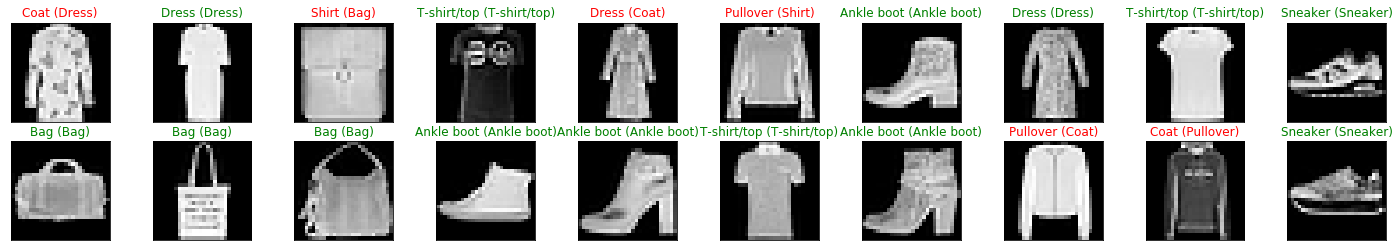

In [50]:
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

### Save Your Best Model

In [60]:
model_path = 'saved_models/fashion_net.pt'

In [61]:
torch.save(net.state_dict(), model_path)

### Load a Trained, Saved Model

To instantiate a trained model, you'll first instantiate a new `Net()` and then initialize it with a saved dictionary of parameters (from the save step above).

In [62]:
net = Net()

In [64]:
net.load_state_dict(torch.load(model_path))

In [65]:
net

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=10, bias=True)
)